<a href="https://colab.research.google.com/github/OstermanEric/Image_Segmentation/blob/main/SAM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Segment Anything Model developed by Meta

# Code used from Facebooks google colab example of SAM
# link: https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb#scrollTo=e0ac8c67

# Environment Set-up

In [ ]:
# Since running from Google Colab, set using_colab=True
# Be sure to select GPU under Edit -> Notebook Settings -> Hardware Accelerator
# Need to use GPU since very intensive program
using_colab = True

In [ ]:
# mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# unzipping files
# same dataset as assignment 2
!unzip '/content/drive/Shareddrives/CSE320 Final Project/CT-CASE15-20231026T211955Z-001.zip'

Archive:  /content/drive/Shareddrives/CSE320 Final Project/CT-CASE15-20231026T211955Z-001.zip
  inflating: CT-CASE15/000499.dcm    
  inflating: CT-CASE15/000500.dcm    
  inflating: CT-CASE15/000505.dcm    
  inflating: CT-CASE15/000494.dcm    
  inflating: CT-CASE15/000477.dcm    
  inflating: CT-CASE15/000492.dcm    
  inflating: CT-CASE15/000493.dcm    
  inflating: CT-CASE15/000504.dcm    
  inflating: CT-CASE15/000488.dcm    
  inflating: CT-CASE15/000507.dcm    
  inflating: CT-CASE15/000480.dcm    
  inflating: CT-CASE15/000496.dcm    
  inflating: CT-CASE15/000486.dcm    
  inflating: CT-CASE15/000484.dcm    
  inflating: CT-CASE15/000497.dcm    
  inflating: CT-CASE15/000491.dcm    
  inflating: CT-CASE15/000506.dcm    
  inflating: CT-CASE15/000482.dcm    
  inflating: CT-CASE15/000490.dcm    
  inflating: CT-CASE15/000501.dcm    
  inflating: CT-CASE15/000489.dcm    
  inflating: CT-CASE15/000478.dcm    
  inflating: CT-CASE15/000487.dcm    
  inflating: CT-CASE15/000498.dc

In [ ]:
# import PyTorch, Torchvision, CUDA
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    # installing the model and a few other dependencies
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    # create new folder to hold output images
    !mkdir images
    # original path to get data to experiment with i.e. pictures of dogs
    #!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.1.0+cu118
Torchvision version: 0.16.0+cu118
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-jvii3l64
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-jvii3l64
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36587 sha256=922c8e83b38de24a3ab9b6475e7ae63d583e1dedab7ad98d02b90ea52ba8d936
  Stored in directory: /tmp/pip-ephem-wheel-cache-yl65mb35/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2023-12-06 22:01:15--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.34, 3.162.163.19, 3.

In [ ]:
# install a few more dependencies
!pip install -q pydicom
!pip install -q matplotlib
# used for bounding box when segmenting interactively
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.6/77.6 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver d

In [ ]:
# importing packages for manipulating, reading, and displaying data
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from glob import glob
import pydicom
import os
import numpy as np

In [ ]:
# getting data from unzipped files
data_path = "/content/CT-CASE15"
output_path = working_path = "/content/output/"
g = glob(data_path+'/*')

# print out first 5 file names to verify were in right folder
print("Total of %d DICOM images. \nFirst 5 filenames:" % len(g))

first5img = '\n'.join(g[:5])
print(first5img)

Total of 508 DICOM images. 
First 5 filenames:
/content/CT-CASE15/000127.dcm
/content/CT-CASE15/000222.dcm
/content/CT-CASE15/000121.dcm
/content/CT-CASE15/000226.dcm
/content/CT-CASE15/000248.dcm


In [ ]:
# loading slices from read-in files from .zip folder
def load_scan(path):
  slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
  slices.sort(key = lambda x: int(x.InstanceNumber))
  try:
    slice_thickness = np.abs(slices[0].ImagesPositionPatient[2] - slices[1].ImagePositionPatient[2])
  except:
    slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)

  for s in slices:
    s.SliceThickness = slice_thickness

  return slices

patient = load_scan(data_path)

In [ ]:
def get_pixels_hu(scans):
  image = np.stack([s.pixel_array for s in scans], axis=-1)
  # convert to int16
  image = image.astype(np.int16)

  # The intercept is usually -1024, so air is approximately 0
  image[image == -3000] = 0

  # convert to Hounsfield units (HU)
  intercept = scans[0].RescaleIntercept
  slope = scans[0].RescaleSlope

  if slope != 1:
    image = slope * image.astype(np.float64)
    image = image.astype(np.int16)

  image += np.int16(intercept)

  return np.array(image, dtype=np.int16)
# NDArray int[16]
img = get_pixels_hu(patient)

In [ ]:
# check data shape
from scipy import ndimage
# rotate so that it is in proper position
img_new = ndimage.rotate(img, -90, reshape=False)
# (512, 512, 508)
img_new.shape

(512, 512, 508)

In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

# **Mask Generation**

For the mask generation, the function mask_generator.generate() takes in file types of .png or .jpeg, not .dcm. Because of this, we implemented a helper function to do so without losing valuable information.

After converting the image, Meta's model allows for easy plug-in to the function which generates the first image segmenting many different areas within the image.

In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
# needs to use GPU to run intensive model
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
# helper functiopn that converts .dcm images to .png format so that it can be used in .generate() method for masks
import pydicom
from PIL import Image

def convert_dicom_to_image(dicom_path, output_path, output_format='PNG'):
    # Read the DICOM file
    dicom_data = pydicom.dcmread(dicom_path)

    # Get pixel data
    pixel_array = dicom_data.pixel_array

    # Normalize pixel values to 0-255
    img_data = (pixel_array / pixel_array.max() * 255).astype('uint8')

    # Create a dummy third dimension to simulate an RGB image
    img_data_rgb = np.stack((img_data, img_data, img_data), axis=-1)

    # Create a PIL Image
    img = Image.fromarray(img_data_rgb, mode='RGB')

    # Save the image in the specified format
    img.save(output_path, format=output_format)



In [ ]:
# selected random file to showcase but works for all files in dataset
dicom_file_path = '/content/CT-CASE15/000109.dcm'
# making new output folder
#!mkdir images
output_image_path = '/content/images/000109.png'
convert_dicom_to_image(dicom_file_path, output_image_path)

(512, 512, 3)
(512, 512)


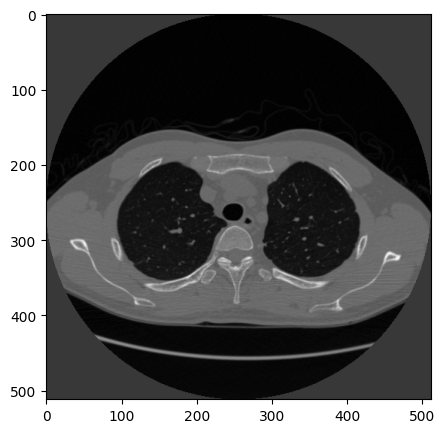

In [ ]:
# displaying the image as .png
from skimage.io import imread
image = imread('/content/images/000109.png')
print(image.shape)
dicom_image = imread(dicom_file_path)
print(dicom_image.shape)
plt.figure(figsize=(5,5))
plt.imshow(image)
plt.axis('on')
plt.show()

In [ ]:
# generating the mask with data converted to .png
sam_result = mask_generator.generate(image)

In [ ]:
# printing the different attributes the mask has
print(sam_result[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


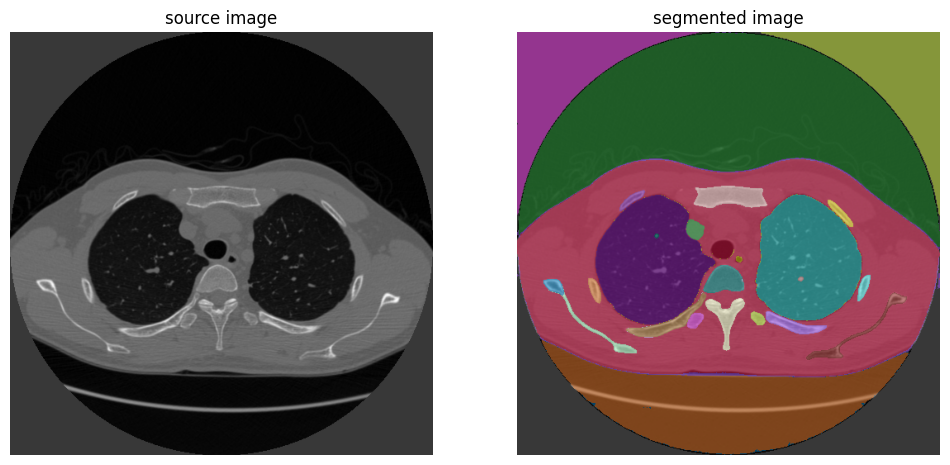

In [ ]:
import supervision as sv
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)

sv.plot_images_grid(
    images=[image, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [ ]:
mask_predictor = SamPredictor(sam)

# Mask Creation from user-determined bounding box

These code blocks allow for the user to draw a bounding box around an area of the image that they want segmented. This area is fed in as input to a function which segments the area and adds a color to it to differentiate the segmented area and original image.

In [ ]:
# helped function to encode image into base64
import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [ ]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
# encoding image into base64 using helper function above
widget.image = encode_image('/content/images/000109.png')
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [ ]:
widget.bboxes

[{'x': 96, 'y': 186, 'width': 323, 'height': 166, 'label': ''}]

In [ ]:
import numpy as np

# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

In [ ]:
import cv2
import numpy as np
import supervision as sv
# initial image read in as png
image_bgr = cv2.imread('/content/images/000109.png')
# image converted to color (RGB)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# predictor function using RGB photo
mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)



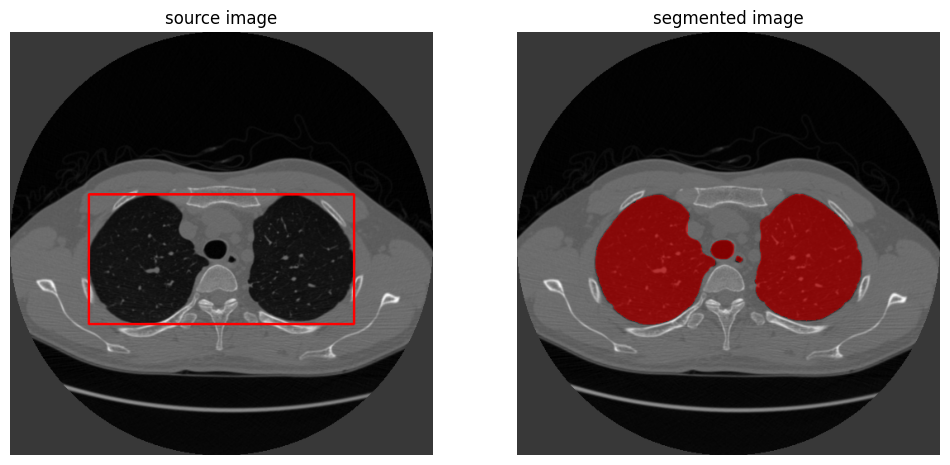

In [ ]:
box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red(), color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)
# showing difference betwene original image and segmented image after using bounding box
sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

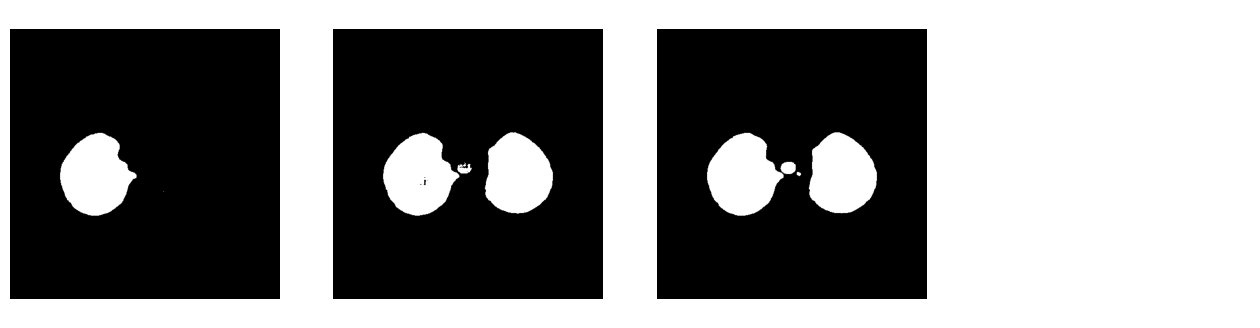

In [ ]:
import supervision as v
# plotting image using bounding box
sv.plot_images_grid(
    images=masks,
    grid_size=(1, 4),
    size=(16, 4)
)

# Mask Creation from 2 points on 2D image

These code blocks segment the image using the SAM model wituout the user interface bounding box. Instead, it used 2 points on the image to tell the model where to segment.

In [ ]:
# helper functions

# method to show the mask by itself
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

# method to show the mask overlaid on top of original image with color depciting mask
def show_masks_on_image(raw_image, masks, scores):
  # have to squeeze out a dimension in order for it to be 3 so that it can be displayed properly
    if len(masks.shape) == 4:
      masks = masks.squeeze()
    if scores.shape[0] == 1:
      scores = scores.squeeze()

    nb_predictions = scores.shape[-1]
    fig, axes = plt.subplots(1, nb_predictions, figsize=(15, 15))

    for i, (mask, score) in enumerate(zip(masks, scores)):
      mask = mask.cpu().detach()
      axes[i].imshow(np.array(raw_image))
      show_mask(mask, axes[i])
      axes[i].title.set_text(f"Mask {i+1}, Score: {score.item():.3f}")
      axes[i].axis("off")
    plt.show()

In [ ]:
import torch
from PIL import Image
import requests
from transformers import SamModel, SamProcessor

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")


# loading image and opening it
image_bgr = cv2.imread('/content/images/000109.png')
ex = Image.open('/content/images/000109.png').convert("RGB")
# points on original image to segment
# two points works better than one from experimentation
input_point = [[[150,300], [350, 300]]]
inputs = processor(ex, input_points=input_point, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu()
)
# printing scores of masks
scores = outputs.iou_scores
tests = masks[0]

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.56G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

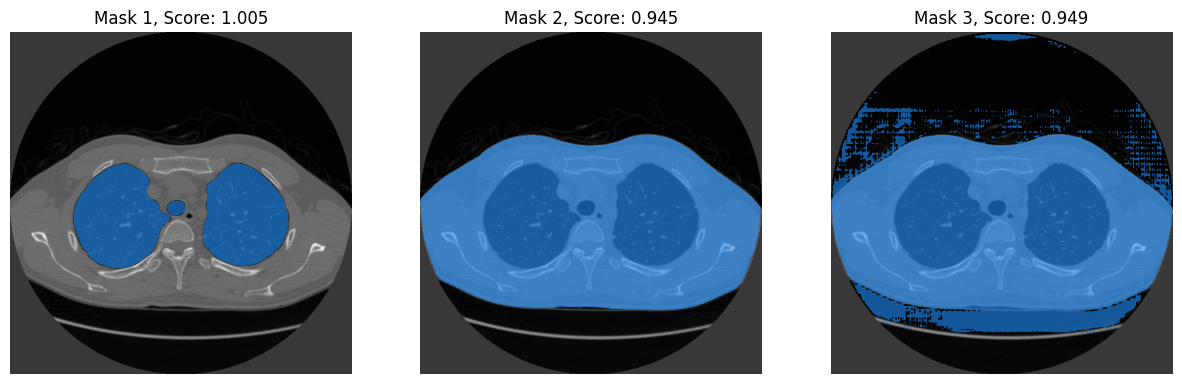

In [ ]:
show_masks_on_image(ex, masks[0], scores)